<font size="6"><code style="background:teal;color:white">Кейс 9: Игровая аналитика</code></font>

Ключевые пункты задания:  
- В июне ребята запустили новый функционал и теперь хотят отследить, как это повлияло на аудиторию. Если аудитория не приняла нововведение, то лучше сразу от него отказаться либо внести изменения.  
- Для понимания эффективности нового функционала вам нужно посчитать показатели **Retention** и **ARPU** за два периода: за **май 2019** (до введения функционала) и **июнь 2019** (после).

<div class="alert alert-block alert-warning"><b>Важно:</b> ниже в ноутбуке приведены вычисления за июнь 2019. Данные за май были просчитаны аналогичным образом и отражены в итоговых выводах. Также для визуализации была использована библиотека plotly, хотя в задании указывалось seaborn - в силу предпочтения интерактивной визуализации.<br>Первая часть работы сделана по аналогии, указанной на обучающей платформе, автор кейса - Руслан Казанцев. Сводная таблица ARPU, визуализация всех показателей сделана самостоятельно (указывались библиотеки seaborn, matplotlib для задания, но в силу интерактивности отдано предпочтение plotly).</div>

In [1]:
#Импортируем нужные библиотеки:
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objects as go
init_notebook_mode(connected=True)

**Считаем Retention**

In [2]:
#Подсчитаем количество зарегистрировавшихся пользователей за июнь 2019 в разрезе дней регистрации registration_date
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory', 
                            user='skillfactory', 
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [3]:
#Посмотрим на информацию о датафрейме:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       30 non-null     object
 1   registered_users_count  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


In [4]:
#Преобразуем registration_date в объект datetime:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [5]:
#Посмотрим на наш датафрейм:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


In [6]:
#Всего за июнь зарегистрировались:
registered_users_count['registered_users_count'].sum()

100423

Получим данные об активных пользователях из базы и подсчитаем по дням количество активных пользователей active_users_count с указанием даты регистрации registration_date. Дата регистрации будет выступать когортой.

In [7]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory', 
                            user='skillfactory', 
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [8]:
#Посмотрим на информацию о датафрейме active_users_count_with_cohorts:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       930 non-null    object
 1   registration_date   930 non-null    object
 2   active_users_count  930 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [9]:
# Как видно, колонки с датами также имеют тип object, то есть строковый тип. Преобразуем их к типу datetime:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [10]:
# Оценим первые строки датафрейма active_users_count_with_cohorts:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


In [11]:
#Объединяем две таблицы:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255


In [12]:
#Считаем Retention Rate:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


In [13]:
#Определяем, какое количество дней прошло с момента регистрации до определенного дня активности:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

In [14]:
#Приводим тип данных в колонке lifetime к целому числу:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

In [15]:
retention_table.head(10)

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,0.341610,0
1,2019-06-02,2019-06-01,1429,4833,0.295676,1
2,2019-06-02,2019-06-02,1933,5255,0.367840,0
3,2019-06-03,2019-06-01,1021,4833,0.211256,2
4,2019-06-03,2019-06-02,1550,5255,0.294957,1
5,2019-06-03,2019-06-03,1432,4193,0.341522,0
6,2019-06-04,2019-06-01,849,4833,0.175667,3
7,2019-06-04,2019-06-02,1163,5255,0.221313,2
8,2019-06-04,2019-06-03,1244,4193,0.296685,1
9,2019-06-04,2019-06-04,1473,4194,0.351216,0


In [16]:
#Сформируем сводную таблицу:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='mean')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.341610,0.295676,0.211256,0.175667,0.143596,0.134906,0.121664,0.112766,0.110904,0.099938,...,0.060418,0.061246,0.058763,0.055245,0.056487,0.050693,0.049659,0.050693,0.042003,0.028968
2019-06-02,0.367840,0.294957,0.221313,0.188202,0.164225,0.145576,0.130923,0.129971,0.121598,0.109610,...,0.073073,0.071931,0.068506,0.062797,0.061656,0.062797,0.063178,0.060514,0.044719,0.028925
2019-06-03,0.341522,0.296685,0.207727,0.173384,0.150727,0.123062,0.118054,0.115430,0.111376,0.099213,...,0.065109,0.064870,0.063916,0.057238,0.056284,0.051753,0.052707,0.051991,0.041975,0.028858
2019-06-04,0.351216,0.296853,0.229852,0.180019,0.147592,0.133047,0.135670,0.121841,0.106581,0.098236,...,0.063662,0.060324,0.058417,0.053648,0.051502,0.051979,0.051264,0.047926,0.036242,0.023605
2019-06-05,0.337419,0.305403,0.223112,0.172336,0.147324,0.140570,0.131816,0.118059,0.108304,0.097799,...,0.066033,0.064282,0.060030,0.056278,0.054527,0.054527,0.053527,0.051026,0.037519,0.027514
2019-06-06,0.362845,0.306551,0.208802,0.178864,0.169396,0.141505,0.131013,0.117707,0.109519,0.098516,...,0.066018,0.063715,0.064483,0.057318,0.056551,0.055015,0.055527,0.055271,0.045803,0.030194
2019-06-07,0.370719,0.294691,0.219290,0.190386,0.171222,0.147345,0.129752,0.120955,0.108702,0.106189,...,0.068803,0.068803,0.068175,0.068175,0.063776,0.064719,0.062834,0.059692,0.045240,0.027961
2019-06-08,0.361902,0.330097,0.251423,0.204553,0.179444,0.156344,0.144961,0.141948,0.127218,0.116170,...,0.076666,0.071979,0.072648,0.071979,0.067626,0.066622,0.066622,0.065618,0.052896,0.037496
2019-06-09,0.363961,0.321811,0.234835,0.192685,0.165923,0.149643,0.143845,0.136039,0.118198,0.113069,...,0.081401,0.074710,0.071142,0.066905,0.068020,0.065343,0.066236,0.062444,0.049286,0.031891


In [17]:
#Сделаем визуализацию для нее:
data=[go.Heatmap(
                x=retention_table.lifetime,
                y=retention_table.registration_date,
                z=[i*100 for i in retention_table.retention_rate.values.tolist()],
                hovertemplate=
                '<b>Date</b>: %{y}'+
                '<br><b>Lifetime</b>: %{x}'+
                '<br><b>Rate<b>: %{z:.2f} %<extra></extra>',
                colorscale='viridis')]
layout=go.Layout(title='Cohorts: User Retention',
                yaxis_title='cohorts',
                xaxis_title='lifetime',
                xaxis=dict(
                dtick=1),
                 yaxis=dict(
                 tickmode='linear')
                )
fig=go.Figure(data=data, layout=layout)
fig.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b> На основании тепловой карты можно проследить максимальные значения retention в lifetime дни 0 и 1, минимальны для 30 дня lifetime. Также существуют менее активные когорты, зарегистрированные 27, 22, 17, 14, 1 июня. Интересный факт, что согласно полученным данным retention на lifetime день 0 не 100%, хотя все кто зарегистрировались в этот день и являлись активными пользователями. Поскольку такие показатели были даны на самой платформе, считаем по предоставленным данным.
</div>

С помощью retention_pivot удобно визуализировать, как изменяется Retention Rate по каждой когорте с течением времени. Например, построим как в зависимости от когорты изменяется Retention Rate на 0-й день:

In [18]:
lifetime=0 #можно поменять поставить интересующее значение lifetime
values=[i*100 for i in retention_pivot[lifetime].values.tolist()]
fig = go.Figure()

data=[go.Bar(
    x=retention_pivot.index, 
    y=[i for i in values],
    text=[str(round(i,2))+' %' for i in values],
    textposition='auto',
    hovertemplate="%{x}: <br>%{y:.2f} %<extra></extra>",
    marker_color='teal')]

layout=go.Layout(title='Cohorts: Retention Rate at {} lifetime'.format(lifetime), 
                yaxis_title='Retention Rate, %',
                xaxis_title='Cohorts',
                 plot_bgcolor='white',
                xaxis=dict(
                tickangle=-45,
                zeroline=False,
                showgrid=False,
                showticklabels=True,
                linecolor='rgb(204, 204, 204)',
                tickmode='linear'
                ),
                 yaxis=dict(
                showgrid=True,
                showline=False,
                zeroline=True,
                gridcolor='rgb(204, 204, 204)'
                ))

fig=go.Figure(data, layout)

fig.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b> Retention rate в нулевой день жизни по когортам остался относительно неизменным, в отличие от данного показателя за май - там наблюдалось его падение в когортах дат ближе к концу месяца:
</div>

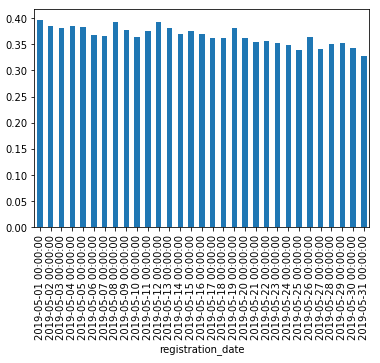

In [19]:
#Добавим среднее значение по lifetime для построения графика:
retention_pivot.loc['mean']=retention_pivot.mean(axis=0)
retention_pivot.tail()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-27 00:00:00,0.336085,0.283019,0.202044,0.166274,0.141509,0.121462,0.111635,0.101808,0.092374,0.088836,...,0.047956,0.048742,0.045204,0.043239,0.041274,0.041667,0.038915,0.039308,0.029874,0.020833
2019-06-28 00:00:00,0.323673,0.295918,0.213061,0.184082,0.153469,0.138776,0.123265,0.116735,0.109388,0.100000,...,0.059592,0.054694,0.055102,0.055102,0.057143,0.050612,0.052653,0.048980,0.035510,0.022041
2019-06-29 00:00:00,0.348720,0.319407,0.236523,0.197102,0.167790,0.151954,0.137466,0.128032,0.122305,0.115903,...,0.071429,0.073787,0.068396,0.062668,0.059636,0.056941,0.056267,0.057951,0.043464,0.029987
2019-06-30 00:00:00,0.371100,0.328688,0.241442,0.200242,0.172372,0.156619,0.152075,0.149349,0.134808,0.127537,...,0.068161,0.065132,0.064223,0.064829,0.063617,0.058467,0.056347,0.059982,0.043623,0.027567
mean,0.350607,0.305707,0.223304,0.186753,0.161584,0.144832,0.134225,0.125151,0.115505,0.106549,...,0.065852,0.063643,0.060973,0.057966,0.056677,0.054686,0.053935,0.052781,0.040779,0.027130


In [20]:
#Построим график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя 
data=go.Scatter(x=['Day {}'.format(i) for i in retention_pivot.columns], 
               y=round(retention_pivot.loc['mean']*100, 2),
                hovertemplate="%{x}: <br>%{y}%<extra></extra>",
                mode='markers+lines', 
               marker=dict(color='teal'))
layout=go.Layout(title='Cohorts: June 2019 Average User Retention',
                yaxis_title='Retention, %',
                plot_bgcolor='white',
                 xaxis=dict(
                tickangle=-45,
                zeroline=False,
                showgrid=False,
                showticklabels=True,
                linecolor='rgb(204, 204, 204)',
                linewidth=3
                ),
                 yaxis=dict(
                showgrid=True,
                showline=False,
                zeroline=True,
                gridcolor='rgb(204, 204, 204)'))
fig=go.Figure(data=data, layout=layout)
fig.show()

<div class="alert alert-block alert-success">
    <b>Вывод:</b> Retention в <b>1-7-30</b> дни соотвественно <b>30,57% - 12,52% - 2,71%</b>, что ниже целевых показателей <b>40-20-10</b>. Необходимо также отметить, что в некоторых источниках данные целевые показатели характерны для 1-7-28 дня, поэтому это скорее ориентир, чем безоговорочное правило. Наилучшим результатом будет итоговое сравнение с показателями предыдущего месяца.
</div>

**Считаем ARPU**  

А теперь перейдем к денежным вопросам, которые будут еще важнее для инвесторов. У нас уже есть датафрейм, в котором хранится информация об активных пользователях — это retention_table.  
Для того, чтобы посчитать ARPU, нам не хватает выручки по дням, разбитой на когорты (как мы делали с retention_table).  
Напишем SQL-запрос, позволяющий получать выручку по дням в разрезе когорт, для пользователей, зарегистрировавшихся в июне 2019 г. Этот запрос обернем функцию getRevenue(), после чего получим данные по запросу и запишем в датафрейм revenue:

In [21]:
# Напишем SQL-запрос, позволяющий получать выручку по дням в разрезе когорт
def getRevenue():
    query = '''SELECT re.date, 
    r.registration_date, 
    count(distinct(re.user_id)) as users_count_with_revenue, 
    sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory', 
                            user='skillfactory', 
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data

revenue = pd.DataFrame(getRevenue())

In [22]:
# Посмотрим основную информацию по колонкам датафрейма revenue:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      833 non-null    object 
 1   registration_date         833 non-null    object 
 2   users_count_with_revenue  833 non-null    int64  
 3   revenue                   833 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


In [23]:
#Как это было с предыдущими датафреймами, колонки с датами содержат тип object. Произведем преобразование типов к datetime:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,1611.860
1,2019-06-02,2019-06-01,928,317.738
2,2019-06-02,2019-06-02,1257,1305.220
3,2019-06-03,2019-06-01,623,192.273
4,2019-06-03,2019-06-02,1008,554.859


In [24]:
#Сумма выручки, которую принесли пользователи, зарегистрировавшиеся в июне:
revenue['revenue'].sum()

79685.865447

Зная два числа — выручку и количество зарегистрировавшихся пользователей — мы можем рассчитать среднюю выручку за 30 дней с пользователя, зарегистрировавшегося в июне:

In [25]:
revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum()

0.7935021404160402

Следующим шагом нужно объединить данные датафрейма revenue с данными датафрейма retention_table. Но до этого следует изменить название колонки date на activity_date в датафрейме revenue. Это нужно для того, чтобы в дальнейшем объединять датафреймы по одинаковому названию колонок.

In [26]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [27]:
# После переименования можно объединить датафреймы в новый датафрейм retention_table_with_revenue:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082.0,1611.860
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928.0,317.738
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257.0,1305.220
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623.0,192.273
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008.0,554.859


In [28]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             930 non-null    datetime64[ns]
 1   registration_date         930 non-null    datetime64[ns]
 2   active_users_count        930 non-null    int64         
 3   registered_users_count    930 non-null    int64         
 4   retention_rate            930 non-null    float64       
 5   lifetime                  930 non-null    int32         
 6   users_count_with_revenue  833 non-null    float64       
 7   revenue                   833 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 61.8 KB


Видим, что после объединения у нас получились пропущенные значения. Это говорит о том, что не во все дни была выручка с пользователей.

In [29]:
# Произведем замену пропущенных значений на 0 с помощью функции fillna():
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [30]:
# Преобразуем тип в колонке users_count_with_revenue в целочисленный:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [31]:
# Рассчитаем ARPU:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] \
/ retention_table_with_revenue['active_users_count'] 
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082,1611.860,0.976293
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928,317.738,0.222350
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257,1305.220,0.675230
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623,192.273,0.188318
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008,554.859,0.357974


In [32]:
#Сформируем сводную таблицу для ARPU:
arpu_pivot=retention_table_with_revenue.pivot_table(index='registration_date', columns='lifetime', values='arpu', aggfunc='mean')
arpu_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.976293,0.222350,0.188318,0.090474,0.056714,0.215960,0.686825,0.323516,0.000000,0.061368,...,0.058239,0.489990,0.210142,0.021039,0.043126,0.171568,0.769008,0.128948,0.027442,0.403106
2019-06-02,0.675230,0.357974,0.213420,0.126478,0.052536,0.213401,0.083839,0.283805,0.076447,0.215764,...,0.022516,0.022901,0.098184,0.050143,0.805546,0.065083,0.011850,0.054992,0.029301,0.596368
2019-06-03,0.717116,0.243213,0.043576,0.126431,0.093071,0.437531,0.074710,0.057345,0.060045,0.070161,...,0.178001,0.048150,0.322848,0.020926,0.044762,0.051013,0.000000,0.000000,0.034498,0.000000
2019-06-04,0.570125,0.280646,0.156369,0.249738,0.207717,0.313095,0.196367,0.107556,0.201097,0.535641,...,0.036031,0.218364,0.000000,0.035660,0.015292,0.050697,0.000000,0.360193,0.000000,0.050684
2019-06-05,0.678426,0.053987,0.524198,0.164261,0.200625,0.003562,0.066171,0.133804,0.119720,0.465517,...,0.077189,0.039368,0.065654,0.278710,0.040788,0.313618,0.131072,0.363810,0.193209,0.246925
2019-06-06,0.864330,0.156215,0.295781,0.367368,0.192799,0.059184,0.268414,0.059151,0.038135,0.145965,...,0.215097,0.031984,0.108535,0.018374,0.153387,0.303742,0.598917,0.103838,0.101861,0.000000
2019-06-07,0.488339,0.439912,0.276970,0.192135,0.182919,0.572635,0.119355,0.149861,0.071297,0.174512,...,0.131543,0.045359,0.000000,0.114296,0.283932,0.036038,0.125212,1.156721,0.075919,0.067893
2019-06-08,0.653629,0.415474,0.192290,0.268525,0.276235,0.334379,0.235961,0.051926,0.131110,0.264527,...,0.093310,0.000000,0.213927,0.000000,0.084135,0.142929,0.146605,0.000000,0.788146,0.078673
2019-06-09,0.910159,0.186660,0.207617,0.137292,0.441263,0.104410,0.246871,0.360654,0.083993,0.102356,...,0.062687,0.000000,0.028893,0.067952,0.018327,0.041019,0.183464,0.000000,0.016263,0.000000


In [33]:
#Сделаем визуализацию для нее:
data=[go.Heatmap(
                x=retention_table_with_revenue.lifetime,
                y=retention_table_with_revenue.registration_date,
                z=retention_table_with_revenue.arpu.values.tolist(),
                hovertemplate=
                '<b>Cohort</b>: %{y}'+
                '<br><b>Lifetime</b>: %{x}'+
                '<br><b>ARPU<b>: %{z:.2f} $<extra></extra>',
                colorscale='viridis')]
layout=go.Layout(title='Cohorts: ARPU',
                yaxis_title='cohorts',
                xaxis_title='lifetime',
                xaxis=dict(
                dtick=1),
                 yaxis=dict(
                 tickmode='linear')
                )
fig=go.Figure(data=data, layout=layout)
fig.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b> Максимальных значений средняя выручка с пользователя достигает в нулевой день его жизни, затем варьируется без видимых закономерностей. 
</div>

In [34]:
#Построим как в зависимости от когорты изменяется ARPU на n-й день lifetime:
lifetime=0 #можно поменять поставить интересующее значение lifetime
values=list(round(arpu_pivot[lifetime], 2))
fig = go.Figure()

data=[go.Bar(
    x=arpu_pivot.index, 
    y=values,
    text=[str(i)+' $' for i in values],
    textposition='auto',
    hovertemplate="%{x}: <br>%{y} $<extra></extra>",
    marker_color='teal')]

layout=go.Layout(title='Cohorts: ARPU at {} lifetime'.format(lifetime), 
                yaxis_title='ARPU $',
                xaxis_title='Cohorts',
                 plot_bgcolor='white',
                xaxis=dict(
                tickangle=-45,
                zeroline=False,
                showgrid=False,
                showticklabels=True,
                linecolor='rgb(204, 204, 204)',
                tickmode='linear'
                ),
                 yaxis=dict(
                showgrid=True,
                showline=False,
                zeroline=True,
                gridcolor='rgb(204, 204, 204)'
                ))

fig=go.Figure(data, layout)

fig.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b> Для нулевого дня жизни средняя выручка с пользователя варьируется от 0,35 \$ (когорта 27 июня) до 1,52 \$ (когорта 26 июня). Видимого тренда не наблюдается.
</div>

In [35]:
#Добавим среднее значение по когортам для построения графика:
arpu_pivot.loc['mean']=arpu_pivot.mean(axis=0)
arpu_pivot.tail()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-27 00:00:00,0.352711,0.102210,0.148729,0.055626,0.392603,0.297842,0.019766,0.056152,0.068749,0.014727,...,0.000000,0.000000,0.034666,0.000000,0.288859,0.051190,0.000000,0.000000,0.049041,0.000000
2019-06-28 00:00:00,0.752439,0.094831,0.326073,0.136932,0.231409,0.088971,0.060995,0.059389,0.220655,0.075924,...,0.037730,0.204402,0.750948,0.000000,0.506194,0.365931,0.000000,0.046519,0.316472,0.158306
2019-06-29 00:00:00,0.821921,0.084576,0.076316,0.069038,0.153239,0.125157,0.084352,0.075593,0.018080,0.000000,...,0.000000,0.000000,0.516133,0.000000,0.120737,0.016322,0.735790,0.000000,0.225250,0.061347
2019-06-30 00:00:00,0.866922,0.152547,0.177617,0.008242,0.160418,0.067732,0.009995,0.075083,0.012164,0.026631,...,0.320120,0.025864,0.000000,0.026199,0.014228,0.028145,0.000000,0.000000,0.069819,0.126429
mean,0.748997,0.247612,0.231219,0.226372,0.161454,0.308641,0.175224,0.153147,0.140943,0.234994,...,0.094581,0.099685,0.144491,0.091224,0.153679,0.108511,0.161853,0.124374,0.150843,0.162709


In [36]:
#Построим график изменения среднего ARPU в июне 2019 г. в зависимости от времени жизни пользователя 
data=go.Scatter(x=['Day {}'.format(i) for i in arpu_pivot.columns], 
               y=round(arpu_pivot.loc['mean'], 2),
                hovertemplate="%{x}: <br>%{y} $<extra></extra>",
                mode='markers+lines', 
               marker=dict(color='teal'))
layout=go.Layout(title='Cohorts: June 2019 Average User ARPU',
                yaxis_title='ARPU, $',
                plot_bgcolor='white',
                 xaxis=dict(
                tickangle=-45,
                zeroline=False,
                showgrid=False,
                showticklabels=True,
                linecolor='rgb(204, 204, 204)',
                linewidth=3
                ),
                 yaxis=dict(
                showgrid=True,
                showline=False,
                zeroline=True,
                gridcolor='rgb(204, 204, 204)'))
fig=go.Figure(data=data, layout=layout)
fig.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b> Максимального значения средняя выручка с пользователя наблюдается в нулевой и пятые дни жизни когорты. Хотя значения варьируются от 0,09 \$ до 0,31 \$, не считая нулевого дня жизни, в целом наблюдается тренд на снижение значений с увеличением дней жизни когорт.
</div>

<font size="6"><code style="background:teal;color:white">Выводы по кейсу:</code></font>

По итогам анализа были получены результаты:

<table>
<thead>
<tr><th>Period</th><th>Registered users</th><th>Reten Day 1</th><th>Reten Day 7</th><th>Reten Day 30</th><th>Revenue</th><th>ARPRegUser</th></tr>
</thead>
<tbody>
<tr><td>May 2019</td><th>188 943</th><td>31.43 %</td><td>13.77%</td><td>2.66 %</td><th>121 998 \$</th><th>0.65 \$</th></tr>
<tr><td>June 2019</td><th>100 423</th><td>30.57 %</td><td>12.52 %</td><td>2.71 %</td><th>79 686 \$</th><th>0.79 \$</th></tr>
</tbody>
</table>


<blockquote><p><b>Вывод:</b> С введением нового функционала в игру наблюдается снижение количества зарегистрированных пользователей на 47%, снижение выручки на 35%, также упали показатели удержания на 1 и 7 день на 3% и 9% соотвественно. Увеличение показали показатели удержания на 30 день (на 2%) и ARPRegUser - с 0.65 \$ до 0.79 \$. Как результат, мы видим ухудшение показателей с вводом нового функционала.<br>
<b>Рекомендации:</b> Необходимо также дополнительно проанализировать маркетинговую активность в данном периоде - за счет какого фактора произошло снижение количества зарегистрированных пользователей (соотношение paid users и organics в обоих периодах). Увеличение долгосрочного удержания дает нам возможность предполагать, что новый функционал связан именно с данным этапом (новый сюжет, пласт игры?). Уменьшение показателей удержания первого и седьмого дня, а также увеличение ARPRegUser дает нам возможность предположения о более агрессивном навязывании платящего контента.<br> На данном этапе новый функционал не показал хорошие результаты. Более точную рекомендацию (изменить функционал или полностью отказаться) можно дать только при точном понимании самого игрового процесса, нового функционала и дополнительных исследованиях.</p>
</blockquote>